In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
import joblib
import pyodbc
import urllib
import json
from datetime import datetime, date
from sqlalchemy import create_engine 
import sys
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

/Users/anson_wang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Test the New Py File

In [2]:
from datetime import datetime, date
import pandas as pd
import numpy as np
import statsmodels.api as sm
import joblib
import json

def ibvmodel(jsonstr):
    
    # Load and Read the JSON file
    json_temp = json.loads(jsonstr)

    if True:
        # Load Json file's historical transaction part
        df_ibv = pd.read_json(json.dumps(json_temp['Historical_Transactions']))

        # Data Cleaning
        df_ibv['IBV_Credit'] = np.where(df_ibv['amount']<0, -1*df_ibv['amount'],0)
        df_ibv['IBV_Debit'] = np.where(df_ibv['amount']>=0, df_ibv['amount'],0)
        df_ibv = df_ibv.rename(columns={'date':'IBV_Date','category':'IBV_BalCategory','name':'IBV_Description'})
        df_ibv['IBV_Date'] = pd.to_datetime(df_ibv['IBV_Date'])
        df_ibv['Year'] = df_ibv['IBV_Date'].apply(lambda x: x.year)
        df_ibv['Month'] = df_ibv['IBV_Date'].apply(lambda x: x.month)
        df_ibv = df_ibv[['account_id','IBV_Credit','IBV_Debit','IBV_Date','Year','Month','IBV_BalCategory','IBV_Description']]
        df_ibv['isLoan'] = df_ibv.IBV_BalCategory.apply(lambda x: 1 if x in [["Service","Financial","Loans and Mortgages"],
                                            ["Travel and Transportation","Auto Loan"], ["Education","Student Loan"],
                                            ["Miscellaneous","Point of Sale Loan"],["Miscellaneous","Insolvency Loan"],
                                            ["Miscellaneous","Other Loan"],["Miscellaneous","Micro Loan"]] else 0)
        df_ibv['regularPayroll'] = df_ibv.IBV_BalCategory.apply(lambda x: 1 if x in [["Transfer","Payroll"], ["Transfer","Payroll",'Benefits'],
                                    ["Income","Pension"],["Income","Government"],["Income","Wages and Salary"]] else 0)
        df_ibv['isFees'] = df_ibv.IBV_BalCategory.apply(lambda x: 1 if (x in [["Bank Fees","ATM"],["Bank Fees","Cash Advance"],
                                                ["Bank Fees","Excess Activity"], ["Bank Fees","Foreign Transaction"],
                                                ["Bank Fees","Fraud Dispute"],["Bank Fees","Insufficient Funds"],
                                                ["Bank Fees","Late Payment"], ["Bank Fees","Overdraft"],
                                                ["Bank Fees","Wire Transfer"],["Bank Fees"],
                                                ["Fees and Charges","ATM Fees"], ["Fees and Charges","Service Fees"]]) else 0)
        df_ibv['isNSFFees'] = df_ibv.IBV_BalCategory.apply(lambda x: 1 if (x in [["Bank Fees","Insufficient Funds"],["Bank Fees","Overdraft"],
                                            ["Fees and Charges","Service Fees"]]) else 0)
        df_ibv['isDeposit'] = df_ibv.IBV_BalCategory.apply(lambda x: 1 if (x in [["Transfer","Deposit","ATM"],
                                                ["Transfer","Deposit","Check"],["Transfer","Deposit"], ["Miscellaneous Income","Deposit"]]) else 0)
        df_ibv['IBV_BalCategory'] = df_ibv['IBV_BalCategory'].apply(str)
        accountid = df_ibv['account_id'].values[0]

        # Load Json file's historical balance part
        primary_account_info = [i for i in json_temp['Historical_Balance']['report']['items'][0]['accounts'] 
                            if i['account_id']==df_ibv.account_id.values[0]]
        if primary_account_info == []:
            df_balance = pd.DataFrame( [[0.00, '2023-02-06', 'CAD' , None]], columns = ['IBV_Balance','date',
                                                        'iso_currency_code', 'unofficial_currency_code'] )
        else:
            df_balance = pd.DataFrame(primary_account_info[0]['historical_balances'])
            df_balance = df_balance.rename(columns={'current':'IBV_Balance'})
        df_balance.date = pd.to_datetime(df_balance.date)
        
        ### Make sure you change it!!!
        curdate = date.today()
        curdate = df_balance['date'].max().date() # remove it before deployment
        
        df_balance['within_last_7day'] = df_balance.apply(lambda x: (curdate - x['date'].date()).days<=7, axis=1)
        ## Step 2: Feature Generation for IBV: to get the input of IBV_Model

        # Feature Generation

        # # Max History
        f1 = pd.DataFrame([[df_ibv.account_id.values[0],(df_ibv['IBV_Date'].max() - df_ibv['IBV_Date'].min()).days]],
                      columns = ['account_id','MaxHistory'])

        # # CREDIT_TO_DEBIT_RATIO_MEAN, CREDIT_TO_DEBIT_RATIO_SD
        f2 = df_ibv.groupby(['account_id','Year','Month']).sum()[['IBV_Credit','IBV_Debit']].reset_index()
        f2['CREDIT_TO_DEBIT_RATIO'] = f2['IBV_Credit'] / f2['IBV_Debit']
        f2 = f2.groupby('account_id').agg({'CREDIT_TO_DEBIT_RATIO':['mean','std']}).reset_index()
        f2.columns = ['account_id','CREDIT_TO_DEBIT_RATIO_MEAN','CREDIT_TO_DEBIT_RATIO_SD']

        # # DAILY_DEBIT_AMOUNT_MEAN, DAILY_INCOME_MEAN
        f3 = df_ibv[df_ibv.isLoan==0].groupby(['account_id','Year','Month']).sum()[['IBV_Credit','IBV_Debit']].reset_index()
        f3['IBV_Credit'] = f3['IBV_Credit'] / 30
        f3['IBV_Debit'] = f3['IBV_Debit'] / 30
        f3 = f3.groupby('account_id').mean()[['IBV_Debit','IBV_Credit']].reset_index()
        f3.columns = ['account_id','DAILY_DEBIT_AMOUNT_MEAN','DAILY_INCOME_MEAN']

        # # DAILY_INCOME_REGULAR_MEAN
        f4 = df_ibv[df_ibv.regularPayroll==1].groupby(['account_id','Year','Month']).sum()['IBV_Credit'].reset_index()
        f4['IBV_Credit'] = f4['IBV_Credit'] / 30
        f4 = f4.groupby('account_id').mean()['IBV_Credit'].reset_index()
        f4.columns = ['account_id','DAILY_INCOME_REGULAR_MEAN']

        # # DEBIT_AMOUNT_AVG, DEBIT_AMOUNT_SD, DEBIT_COUNT_AVG,DEBIT_COUNT_SD
        f5 = df_ibv.groupby(['account_id','Year','Month']).sum()['IBV_Debit'].reset_index()
        f5 = f5.groupby('account_id').agg({'IBV_Debit':['mean','std']}).reset_index()
        f5.columns = ['account_id','DEBIT_AMOUNT_MEAN','DEBIT_AMOUNT_SD']

        f6 = df_ibv[df_ibv.IBV_Debit>0].groupby(['account_id','Year','Month']).count()['IBV_Debit'].reset_index()
        f6 = f6.groupby('account_id').agg({'IBV_Debit':['mean','std']}).reset_index()
        f6.columns = ['account_id','DEBIT_COUNT_MEAN','DEBIT_COUNT_SD']

        # # DEBIT_AMOUNT_Z, DEBIT_COUNT_Z
        f71 = df_ibv.groupby(['account_id','Year','Month']).sum()['IBV_Debit'].reset_index().sort_values(by=['account_id','Year','Month'],ascending=False)
        f71 = f71.groupby('account_id').first().reset_index()[['account_id','IBV_Debit']]
        f71 = f71.merge(f5,on='account_id')
        f71['DEBIT_AMOUNT_Z'] = (f71['IBV_Debit'] - f71['DEBIT_AMOUNT_MEAN'])/f71['DEBIT_AMOUNT_SD']

        f72 = df_ibv[df_ibv.IBV_Debit>0].groupby(['account_id','Year','Month']).count()['IBV_Debit'].reset_index().sort_values(by=['account_id','Year','Month'],ascending=False)
        f72 = f72.groupby('account_id').first().reset_index()[['account_id','IBV_Debit']]
        f72 = f72.merge(f6,on='account_id')
        f72['DEBIT_COUNT_Z'] = (f72['IBV_Debit'] - f72['DEBIT_COUNT_MEAN'])/f72['DEBIT_COUNT_SD']

        f7 = f71[['account_id', 'DEBIT_AMOUNT_Z']].merge(f72[['account_id','DEBIT_COUNT_Z']], on='account_id', how='left')


        # # HIGHEST_PAY_DEPOSIT_MEAN, HIGHEST_PAY_FREQUENCY
        f81 = df_ibv.groupby(['account_id','IBV_BalCategory','Year','Month']).sum()['IBV_Credit'].reset_index()
        f81 = f81.groupby(['account_id','IBV_BalCategory']).mean()['IBV_Credit'].reset_index().sort_values(by=['account_id','IBV_Credit','IBV_BalCategory'],ascending=False)
        f82 = f81.groupby('account_id').first().reset_index()[['account_id','IBV_BalCategory']]
        f8 = f81.merge(f82, on =['account_id','IBV_BalCategory'], how='inner')[['account_id','IBV_Credit']]
        f8.columns = ['account_id','HIGHEST_PAY_DEPOSIT_MEAN']

        f9 = df_ibv[df_ibv.IBV_Credit>0].merge(f82, on =['account_id','IBV_BalCategory'], how='inner').groupby(['account_id','Year','Month']).count()['IBV_Credit'].reset_index()
        f9 = f9.groupby('account_id')['IBV_Credit'].mean().reset_index()[['account_id','IBV_Credit']]
        f9.columns = ['account_id','HIGHEST_PAY_FREQUENCY']

        # # INCOME_SOURCES_COUNT
        f10 = df_ibv[(df_ibv.IBV_Credit>0)&(df_ibv.IBV_BalCategory.isin(['income/investment_income','income/paycheck','income/bonus','income/government',
        'income','income/pension','income/child_support']))].groupby(['account_id','IBV_BalCategory']).size().reset_index()
        f10 = f10.groupby('account_id').size().reset_index()
        f10.columns = ['account_id','INCOME_SOURCES_COUNT']



        # # MONTH_INFLOW_MEAN, MONTH_INFLOW_SD, MONTH_OUTFLOW_MEAN, MONTH_OUTFLOW_SD
        f11 = df_ibv.groupby(['account_id','Year','Month']).sum()[['IBV_Credit','IBV_Debit']].reset_index()
        f11 = f11.groupby('account_id').agg({'IBV_Credit':['mean','std'],'IBV_Debit':['mean','std']}).reset_index()
        f11.columns = ['account_id','MONTH_INFLOW_MEAN', 'MONTH_INFLOW_SD', 'MONTH_OUTFLOW_MEAN', 'MONTH_OUTFLOW_SD']


        # #MONTHS_WITH_FEES_RATE
        f12_ = df_ibv.copy()
        f12 = f12_.groupby(['account_id','Year','Month']).sum()['isFees'].reset_index()
        f12['MONTHS_WITH_FEES_RATE'] = np.where(f12['isFees']>0,1.0,0.0)
        f12 = f12.groupby('account_id').mean()['MONTHS_WITH_FEES_RATE'].reset_index()[['account_id','MONTHS_WITH_FEES_RATE']]

        # # MONTHS_WITH_EMPLOYMENT_RATE
        f12_['Emp'] = (df_ibv['IBV_BalCategory']=='income/paycheck').astype(int) #!!!!!
        f13 = f12_.groupby(['account_id','Year','Month']).sum()['Emp'].reset_index()
        f13['MONTHS_WITH_EMPLOYMENT_RATE'] = np.where(f13['Emp']>0,1.0,0.0)
        f13 = f13.groupby('account_id').mean()['MONTHS_WITH_EMPLOYMENT_RATE'].reset_index()[['account_id','MONTHS_WITH_EMPLOYMENT_RATE']]

        # # NO_ACTIVITY_RATE
        f14 = df_ibv.groupby('account_id')['IBV_Date'].nunique().reset_index()
        f14 = f14.merge(f1, on='account_id')[['account_id','IBV_Date','MaxHistory']]
        f14['NO_ACTIVITY_RATE'] = f14['IBV_Date'] / f14['MaxHistory']
        f14 = f14[['account_id','NO_ACTIVITY_RATE']]

        # # OD_AND_NSF_FEES_DAILY
        f15 = df_ibv[df_ibv.isNSFFees==1].groupby('account_id')['IBV_Debit'].sum().reset_index()
        f15 = f15.merge(f1, on='account_id')[['account_id','IBV_Debit','MaxHistory']]
        f15['OD_AND_NSF_FEES_DAILY'] = f15['IBV_Debit'] / f15['MaxHistory']
        f15 = f15[['account_id','OD_AND_NSF_FEES_DAILY']]

        # # RECURRENT_COUNT, RECURRENT_RATE
        f16 = df_ibv[df_ibv.IBV_Debit>0].groupby(['account_id', 'Year', 'Month', 'IBV_Debit', 'IBV_BalCategory']).size()
        f16 = f16.groupby(['account_id','IBV_Debit','IBV_BalCategory']).size().reset_index()
        f16.columns = ['account_id','IBV_Debit', 'IBV_BalCategory', 'CNT']
        f16 = f16[(f16['CNT']>=5)&(f16['IBV_Debit']>=10)]
        f16 = f16.groupby('account_id').agg({'IBV_BalCategory':'nunique','IBV_Debit':'sum'}).reset_index()
        f16.columns = ['account_id','RECURRENT_COUNT','RECURRING_RATE']
        
        f17 = pd.DataFrame([[accountid, df_balance['IBV_Balance'].mean(), df_balance['IBV_Balance'].std(),
                            (df_balance['IBV_Balance']>200).mean(), int(df_balance['IBV_Balance'].values[0]>200),
                            int((df_balance[df_balance.within_last_7day==True]['IBV_Balance'].values.mean())>200),
             int((df_balance[df_balance.within_last_7day==True]['IBV_Balance'].mean())>(df_balance[df_balance.within_last_7day==False]['IBV_Balance'].mean())) ]], 
              columns = ['account_id','BALANCE_MEAN','BALANCE_SD','BALANCE_ABOVE_RATE','LAST_BALANCE_ABOVE',
                         'AVG_BALANCE_ABOVE_7D', 'HIGHER_BALANCE_7D'])
        
        # # Red Zone features added by Coral: loan, payroll, deposit, total credit, total debit
        f18 = df_ibv[(df_ibv['isLoan'] == 1)&(df_ibv['IBV_Debit']>60)].groupby('account_id').agg({'IBV_Debit':['count','sum']}).reset_index()
        f18.columns = ['account_id', 'NUM_LOAN_PMT', 'TOTAL_LOAN_PMT_AMT']
        
        f19 = df_ibv[(df_ibv['isLoan'] == 1)&(df_ibv['IBV_Credit']>60)].groupby('account_id').agg({'IBV_Credit':['count','sum']}).reset_index()
        f19.columns = ['account_id', 'NUM_LOAN_ORIG', 'TOTAL_LOAN_ORIG_AMT']
        
        f20 = df_ibv[(df_ibv['regularPayroll']==1) & (df_ibv['IBV_Credit']>50)].groupby('account_id')['IBV_Credit'].sum().reset_index()
        f20.columns = ['account_id','PAYROLL_AMOUNT']
        

        f21 = df_ibv[(df_ibv['isDeposit']==1) & (df_ibv['IBV_Credit']>50)].groupby('account_id')['IBV_Credit'].sum().reset_index()
        f21.columns = ['account_id','DEPOSIT_AMOUNT']
        f22 = df_ibv.groupby('account_id')[['IBV_Credit','IBV_Debit']].sum().reset_index()
        f22.columns = ['account_id','TOTAL_CREDIT','TOTAL_DEBIT']
        
        # # Alert indicators added by Coral: stop payment, nsf, overdraft, return
        stop_keywords = ['e-transfer stop', 'stop payt','stop payment','stop fee','stop pmt','stoppa','stop pymt']
        nsf_keywords = [r"\bnsf", 'NON-SUFFICIENT FUNDS','Insufficient fund','NON SUFFICIENT','Returned Item Fee']
        overdraft_keywords = ['Overdraft', 'Over limit','OD FEE','OD PROTECTION','OD HANDL']
        return_keywords = ['returned', 'RETURN FEE','Return of','EFT.*Return', 'eft.*reversal']
        
        df_ibv['STOP_Incident'] = 0
        df_ibv.loc[(df_ibv['IBV_Description'].str.contains("|".join(stop_keywords), case=False)) & (df_ibv['IBV_Credit']>0), 'STOP_Incident'] = 1
        df_ibv['NSF_Incident'] = 0
        df_ibv.loc[(df_ibv['IBV_Description'].str.contains("|".join(nsf_keywords), case=False)), 'NSF_Incident'] = 1
        df_ibv['OVERDRAFT_Incident'] = 0
        df_ibv.loc[(df_ibv['IBV_Description'].str.contains("|".join(overdraft_keywords), case=False)), 'OVERDRAFT_Incident'] = 1
        df_ibv['RETURN_Incident'] = 0
        df_ibv.loc[(df_ibv['IBV_Description'].str.contains("|".join(return_keywords), case=False)), 'RETURN_Incident'] = 1
        df_ibv.loc[(df_ibv['IBV_Description'].str.contains("|".join(gambling_keywords), case=False)), 'Gambling_Incident'] = \
         df_ibv.loc[(df_ibv['IBV_Description'].str.contains("|".join(gambling_keywords), case=False)), 'IBV_Debit'].values
        
        
        f23 = df_ibv.groupby('account_id').agg(NUM_STOP_PMT = ('STOP_Incident','sum'),
                                               NUM_NSF = ('NSF_Incident','sum'),
                                               NUM_OD = ('OVERDRAFT_Incident','sum'),
                                               NUM_RETURN_PMT = ('RETURN_Incident','sum'),
                                               NUM_GAMBLING_PMT = ('Gambling_Incident', 'count'),
                                               AMT_GAMBLING_PMT = ('Gambling_Incident', 'sum')).reset_index()
      
        ibv_modelinput = f1.copy()
        for i in [f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23]:
            ibv_modelinput = ibv_modelinput.merge(i, on='account_id',how='left')

        # ## Step 3: DataCleaning after feature generation
        ibv_modelinput = ibv_modelinput.fillna(value=0).replace(np.inf, 100).replace(-np.inf, -100)

        # ## Step 4: IBV Model Scoring and IBVBand Assignment based on IBVScore
        ibv_features = ['MaxHistory', 'CREDIT_TO_DEBIT_RATIO_MEAN', 'CREDIT_TO_DEBIT_RATIO_SD',
                'DAILY_DEBIT_AMOUNT_MEAN', 'DAILY_INCOME_MEAN',
                'DAILY_INCOME_REGULAR_MEAN', 'DEBIT_AMOUNT_Z', 'DEBIT_COUNT_Z',
                'HIGHEST_PAY_DEPOSIT_MEAN', 'HIGHEST_PAY_FREQUENCY',
                'INCOME_SOURCES_COUNT', 'MONTH_INFLOW_MEAN', 'MONTH_INFLOW_SD',
                'MONTH_OUTFLOW_MEAN', 'MONTH_OUTFLOW_SD', 'MONTHS_WITH_FEES_RATE',
                'MONTHS_WITH_EMPLOYMENT_RATE', 'NO_ACTIVITY_RATE',
                'OD_AND_NSF_FEES_DAILY', 'RECURRENT_COUNT', 'RECURRING_RATE',
                'BALANCE_MEAN','BALANCE_SD', 'BALANCE_ABOVE_RATE','LAST_BALANCE_ABOVE',
                'AVG_BALANCE_ABOVE_7D', 'HIGHER_BALANCE_7D', 'NUM_LOAN_PMT', 'TOTAL_LOAN_PMT_AMT',
                'NUM_LOAN_ORIG', 'TOTAL_LOAN_ORIG_AMT','PAYROLL_AMOUNT', 'TOTAL_CREDIT','TOTAL_DEBIT',
                'NUM_STOP_PMT','NUM_NSF','NUM_OD','NUM_RETURN_PMT' ]

        # Load Model
#         clf_ibv = joblib.load(modelfilepath)

#         # Get IBV Score (output 1)
#         ibv_modelinput['IBVScore'] = np.round(clf_ibv.predict_proba(ibv_modelinput[ibv_features])[1][:,1][0]*1000,0).astype(int)

#         # Get IBV Band (output 2)
#         ibv_modelinput['IBVBand'] = np.where(ibv_modelinput['IBVScore']< 547,1, 
#                                              np.where(ibv_modelinput['IBVScore']< 719,2, 
#                                             np.where(ibv_modelinput['IBVScore'] < 820,3,4) ) )
    if False:
        try:
            accountid = df_ibv['account_id'].values[0]
            ibv_modelinput = pd.DataFrame( [[accountid] + list(np.zeros(38))],
             columns = ['account_id' ,'MaxHistory', 'CREDIT_TO_DEBIT_RATIO_MEAN', 'CREDIT_TO_DEBIT_RATIO_SD',
                'DAILY_DEBIT_AMOUNT_MEAN', 'DAILY_INCOME_MEAN',
                'DAILY_INCOME_REGULAR_MEAN', 'DEBIT_AMOUNT_Z', 'DEBIT_COUNT_Z',
                'HIGHEST_PAY_DEPOSIT_MEAN', 'HIGHEST_PAY_FREQUENCY',
                'INCOME_SOURCES_COUNT', 'MONTH_INFLOW_MEAN', 'MONTH_INFLOW_SD',
                'MONTH_OUTFLOW_MEAN', 'MONTH_OUTFLOW_SD', 'MONTHS_WITH_FEES_RATE',
                'MONTHS_WITH_EMPLOYMENT_RATE', 'NO_ACTIVITY_RATE',
                'OD_AND_NSF_FEES_DAILY', 'RECURRENT_COUNT', 'RECURRING_RATE',
                'BALANCE_MEAN','BALANCE_SD', 'BALANCE_ABOVE_RATE','LAST_BALANCE_ABOVE',
                'AVG_BALANCE_ABOVE_7D', 'HIGHER_BALANCE_7D', 'NUM_LOAN_PMT', 'TOTAL_LOAN_PMT_AMT',
                'NUM_LOAN_ORIG', 'TOTAL_LOAN_ORIG_AMT','PAYROLL_AMOUNT', 'TOTAL_CREDIT','TOTAL_DEBIT',
                'NUM_STOP_PMT','NUM_NSF','NUM_OD','NUM_RETURN_PMT', 'NUM_GAMBLING_PMT' ,'AMT_GAMBLING_PMT'
                    ])
        except: # If plaid file received is empty: account_id will be 0, or modified to Other value 
            ibv_modelinput = pd.DataFrame( [[0] + list(np.zeros(38))],
             columns = ['account_id' , 'MaxHistory', 'CREDIT_TO_DEBIT_RATIO_MEAN', 'CREDIT_TO_DEBIT_RATIO_SD',
                'DAILY_DEBIT_AMOUNT_MEAN', 'DAILY_INCOME_MEAN',
                'DAILY_INCOME_REGULAR_MEAN', 'DEBIT_AMOUNT_Z', 'DEBIT_COUNT_Z',
                'HIGHEST_PAY_DEPOSIT_MEAN', 'HIGHEST_PAY_FREQUENCY',
                'INCOME_SOURCES_COUNT', 'MONTH_INFLOW_MEAN', 'MONTH_INFLOW_SD',
                'MONTH_OUTFLOW_MEAN', 'MONTH_OUTFLOW_SD', 'MONTHS_WITH_FEES_RATE',
                'MONTHS_WITH_EMPLOYMENT_RATE', 'NO_ACTIVITY_RATE',
                'OD_AND_NSF_FEES_DAILY', 'RECURRENT_COUNT', 'RECURRING_RATE',
                'BALANCE_MEAN','BALANCE_SD', 'BALANCE_ABOVE_RATE','LAST_BALANCE_ABOVE',
                'AVG_BALANCE_ABOVE_7D', 'HIGHER_BALANCE_7D', 'NUM_LOAN_PMT', 'TOTAL_LOAN_PMT_AMT',
                'NUM_LOAN_ORIG', 'TOTAL_LOAN_ORIG_AMT','PAYROLL_AMOUNT', 'TOTAL_CREDIT','TOTAL_DEBIT',
                'NUM_STOP_PMT','NUM_NSF','NUM_OD','NUM_RETURN_PMT', 'NUM_GAMBLING_PMT' ,'AMT_GAMBLING_PMT' ])
    return ibv_modelinput[ibv_features]

In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import statsmodels.api as sm
import joblib
import json
import sys
import logging

def ibvmodel(jsonstr, modelfilepath):
    
    logging.basicConfig(filename="IBVModel_WarningErrorLog_2023.log", level=logging.WARNING, 
            format="%(asctime)s - %(levelname)s - %(message)s")
    stepname = '1 Loading Json'

    try:
        # Load and Read the JSON file
        json_temp = json.loads(jsonstr)
        # Load Json file's historical transaction part
        df_ibv = pd.read_json(json.dumps(json_temp['Historical_Transactions']))

        # Data Cleaning
        stepname = '2 Data Cleaning'
        df_ibv['IBV_Credit'] = np.where(df_ibv['amount']<0, -1*df_ibv['amount'],0)
        df_ibv['IBV_Debit'] = np.where(df_ibv['amount']>=0, df_ibv['amount'],0)
        df_ibv = df_ibv.rename(columns={'date':'IBV_Date','category':'IBV_BalCategory','name':'IBV_Description'})
        df_ibv['IBV_Date'] = pd.to_datetime(df_ibv['IBV_Date'])
        df_ibv['Year'] = df_ibv['IBV_Date'].apply(lambda x: x.year)
        df_ibv['Month'] = df_ibv['IBV_Date'].apply(lambda x: x.month)
        df_ibv = df_ibv[['account_id','IBV_Credit','IBV_Debit','IBV_Date','Year','Month','IBV_BalCategory','IBV_Description']]
        df_ibv['isLoan'] = df_ibv.IBV_BalCategory.apply(lambda x: 1 if x in [["Service","Financial","Loans and Mortgages"],
                                            ["Travel and Transportation","Auto Loan"], ["Education","Student Loan"],
                                            ["Miscellaneous","Point of Sale Loan"],["Miscellaneous","Insolvency Loan"],
                                            ["Miscellaneous","Other Loan"],["Miscellaneous","Micro Loan"]] else 0)
        df_ibv['regularPayroll'] = df_ibv.IBV_BalCategory.apply(lambda x: 1 if x in [["Transfer","Payroll"], ["Transfer","Payroll",'Benefits'],
                                    ["Income","Pension"],["Income","Government"],["Income","Wages and Salary"]] else 0)
        df_ibv['isFees'] = df_ibv.IBV_BalCategory.apply(lambda x: 1 if (x in [["Bank Fees","ATM"],["Bank Fees","Cash Advance"],
                                                ["Bank Fees","Excess Activity"], ["Bank Fees","Foreign Transaction"],
                                                ["Bank Fees","Fraud Dispute"],["Bank Fees","Insufficient Funds"],
                                                ["Bank Fees","Late Payment"], ["Bank Fees","Overdraft"],
                                                ["Bank Fees","Wire Transfer"],["Bank Fees"],
                                                ["Fees and Charges","ATM Fees"], ["Fees and Charges","Service Fees"]]) else 0)
        df_ibv['isNSFFees'] = df_ibv.IBV_BalCategory.apply(lambda x: 1 if (x in [["Bank Fees","Insufficient Funds"],["Bank Fees","Overdraft"],
                                            ["Fees and Charges","Service Fees"]]) else 0)
        df_ibv['isDeposit'] = df_ibv.IBV_BalCategory.apply(lambda x: 1 if (x in [["Transfer","Deposit","ATM"],
                                                ["Transfer","Deposit","Check"],["Transfer","Deposit"], ["Miscellaneous Income","Deposit"]]) else 0)
        df_ibv['IBV_BalCategory'] = df_ibv['IBV_BalCategory'].apply(str)
        accountid = df_ibv['account_id'].values[0]

        # Load Json file's historical balance part
        primary_account_info = [i for i in json_temp['Historical_Balance']['report']['items'][0]['accounts'] 
                            if i['account_id']==df_ibv.account_id.values[0]]
        if primary_account_info == []:
            df_balance = pd.DataFrame( [[0.00, '2023-02-06', 'CAD' , None]], columns = ['IBV_Balance','date',
                                                        'iso_currency_code', 'unofficial_currency_code'] )
        else:
            df_balance = pd.DataFrame(primary_account_info[0]['historical_balances'])
            df_balance = df_balance.rename(columns={'current':'IBV_Balance'})
        df_balance.date = pd.to_datetime(df_balance.date)
            
        curdate = date.today()
        curdate = df_balance['date'].max().date() # remove it before deployment
        
        df_balance['within_last_7day'] = df_balance.apply(lambda x: (curdate - x['date'].date()).days<=7, axis=1)

        ## Step 2: Feature Generation for IBV: to get the input of IBV_Model

        # Feature Generation

        # # Max History
        stepname = '3 Feature Generation'
        
        f1 = pd.DataFrame([[df_ibv.account_id.values[0],(df_ibv['IBV_Date'].max() - df_ibv['IBV_Date'].min()).days]],
                      columns = ['account_id','MaxHistory'])

        # # CREDIT_TO_DEBIT_RATIO_MEAN, CREDIT_TO_DEBIT_RATIO_SD
        f2 = df_ibv.groupby(['account_id','Year','Month']).sum()[['IBV_Credit','IBV_Debit']].reset_index()
        f2['CREDIT_TO_DEBIT_RATIO'] = f2['IBV_Credit'] / f2['IBV_Debit']
        f2 = f2.groupby('account_id').agg({'CREDIT_TO_DEBIT_RATIO':['mean','std']}).reset_index()
        f2.columns = ['account_id','CREDIT_TO_DEBIT_RATIO_MEAN','CREDIT_TO_DEBIT_RATIO_SD']

        # # DAILY_DEBIT_AMOUNT_MEAN, DAILY_INCOME_MEAN
        f3 = df_ibv[df_ibv.isLoan==0].groupby(['account_id','Year','Month']).sum()[['IBV_Credit','IBV_Debit']].reset_index()
        f3['IBV_Credit'] = f3['IBV_Credit'] / 30
        f3['IBV_Debit'] = f3['IBV_Debit'] / 30
        f3 = f3.groupby('account_id').mean()[['IBV_Debit','IBV_Credit']].reset_index()
        f3.columns = ['account_id','DAILY_DEBIT_AMOUNT_MEAN','DAILY_INCOME_MEAN']

        # # DAILY_INCOME_REGULAR_MEAN
        f4 = df_ibv[df_ibv.regularPayroll==1].groupby(['account_id','Year','Month']).sum()['IBV_Credit'].reset_index()
        f4['IBV_Credit'] = f4['IBV_Credit'] / 30
        f4 = f4.groupby('account_id').mean()['IBV_Credit'].reset_index()
        f4.columns = ['account_id','DAILY_INCOME_REGULAR_MEAN']

        # # DEBIT_AMOUNT_AVG, DEBIT_AMOUNT_SD, DEBIT_COUNT_AVG,DEBIT_COUNT_SD
        f5 = df_ibv.groupby(['account_id','Year','Month']).sum()['IBV_Debit'].reset_index()
        f5 = f5.groupby('account_id').agg({'IBV_Debit':['mean','std']}).reset_index()
        f5.columns = ['account_id','DEBIT_AMOUNT_MEAN','DEBIT_AMOUNT_SD']

        f6 = df_ibv[df_ibv.IBV_Debit>0].groupby(['account_id','Year','Month']).count()['IBV_Debit'].reset_index()
        f6 = f6.groupby('account_id').agg({'IBV_Debit':['mean','std']}).reset_index()
        f6.columns = ['account_id','DEBIT_COUNT_MEAN','DEBIT_COUNT_SD']

        # # DEBIT_AMOUNT_Z, DEBIT_COUNT_Z
        f71 = df_ibv.groupby(['account_id','Year','Month']).sum()['IBV_Debit'].reset_index().sort_values(by=['account_id','Year','Month'],ascending=False)
        f71 = f71.groupby('account_id').first().reset_index()[['account_id','IBV_Debit']]
        f71 = f71.merge(f5,on='account_id')
        f71['DEBIT_AMOUNT_Z'] = (f71['IBV_Debit'] - f71['DEBIT_AMOUNT_MEAN'])/f71['DEBIT_AMOUNT_SD']

        f72 = df_ibv[df_ibv.IBV_Debit>0].groupby(['account_id','Year','Month']).count()['IBV_Debit'].reset_index().sort_values(by=['account_id','Year','Month'],ascending=False)
        f72 = f72.groupby('account_id').first().reset_index()[['account_id','IBV_Debit']]
        f72 = f72.merge(f6,on='account_id')
        f72['DEBIT_COUNT_Z'] = (f72['IBV_Debit'] - f72['DEBIT_COUNT_MEAN'])/f72['DEBIT_COUNT_SD']

        f7 = f71[['account_id', 'DEBIT_AMOUNT_Z']].merge(f72[['account_id','DEBIT_COUNT_Z']], on='account_id', how='left')


        # # HIGHEST_PAY_DEPOSIT_MEAN, HIGHEST_PAY_FREQUENCY
        f81 = df_ibv.groupby(['account_id','IBV_BalCategory','Year','Month']).sum()['IBV_Credit'].reset_index()
        f81 = f81.groupby(['account_id','IBV_BalCategory']).mean()['IBV_Credit'].reset_index().sort_values(by=['account_id','IBV_Credit','IBV_BalCategory'],ascending=False)
        f82 = f81.groupby('account_id').first().reset_index()[['account_id','IBV_BalCategory']]
        f8 = f81.merge(f82, on =['account_id','IBV_BalCategory'], how='inner')[['account_id','IBV_Credit']]
        f8.columns = ['account_id','HIGHEST_PAY_DEPOSIT_MEAN']

        f9 = df_ibv[df_ibv.IBV_Credit>0].merge(f82, on =['account_id','IBV_BalCategory'], how='inner').groupby(['account_id','Year','Month']).count()['IBV_Credit'].reset_index()
        f9 = f9.groupby('account_id')['IBV_Credit'].mean().reset_index()[['account_id','IBV_Credit']]
        f9.columns = ['account_id','HIGHEST_PAY_FREQUENCY']

        # # INCOME_SOURCES_COUNT
        f10 = df_ibv[(df_ibv.IBV_Credit>0)&(df_ibv.IBV_BalCategory.isin(['income/investment_income','income/paycheck','income/bonus','income/government',
        'income','income/pension','income/child_support']))].groupby(['account_id','IBV_BalCategory']).size().reset_index()
        f10 = f10.groupby('account_id').size().reset_index()
        f10.columns = ['account_id','INCOME_SOURCES_COUNT']



        # # MONTH_INFLOW_MEAN, MONTH_INFLOW_SD, MONTH_OUTFLOW_MEAN, MONTH_OUTFLOW_SD
        f11 = df_ibv.groupby(['account_id','Year','Month']).sum()[['IBV_Credit','IBV_Debit']].reset_index()
        f11 = f11.groupby('account_id').agg({'IBV_Credit':['mean','std'],'IBV_Debit':['mean','std']}).reset_index()
        f11.columns = ['account_id','MONTH_INFLOW_MEAN', 'MONTH_INFLOW_SD', 'MONTH_OUTFLOW_MEAN', 'MONTH_OUTFLOW_SD']


        # #MONTHS_WITH_FEES_RATE
        f12_ = df_ibv.copy()
        f12 = f12_.groupby(['account_id','Year','Month']).sum()['isFees'].reset_index()
        f12['MONTHS_WITH_FEES_RATE'] = np.where(f12['isFees']>0,1.0,0.0)
        f12 = f12.groupby('account_id').mean()['MONTHS_WITH_FEES_RATE'].reset_index()[['account_id','MONTHS_WITH_FEES_RATE']]

        # # MONTHS_WITH_EMPLOYMENT_RATE
        f12_['Emp'] = (df_ibv['IBV_BalCategory']=='income/paycheck').astype(int) #!!!!!
        f13 = f12_.groupby(['account_id','Year','Month']).sum()['Emp'].reset_index()
        f13['MONTHS_WITH_EMPLOYMENT_RATE'] = np.where(f13['Emp']>0,1.0,0.0)
        f13 = f13.groupby('account_id').mean()['MONTHS_WITH_EMPLOYMENT_RATE'].reset_index()[['account_id','MONTHS_WITH_EMPLOYMENT_RATE']]

        # # NO_ACTIVITY_RATE
        f14 = df_ibv.groupby('account_id')['IBV_Date'].nunique().reset_index()
        f14 = f14.merge(f1, on='account_id')[['account_id','IBV_Date','MaxHistory']]
        f14['NO_ACTIVITY_RATE'] = f14['IBV_Date'] / f14['MaxHistory']
        f14 = f14[['account_id','NO_ACTIVITY_RATE']]

        # # OD_AND_NSF_FEES_DAILY
        f15 = df_ibv[df_ibv.isNSFFees==1].groupby('account_id')['IBV_Debit'].sum().reset_index()
        f15 = f15.merge(f1, on='account_id')[['account_id','IBV_Debit','MaxHistory']]
        f15['OD_AND_NSF_FEES_DAILY'] = f15['IBV_Debit'] / f15['MaxHistory']
        f15 = f15[['account_id','OD_AND_NSF_FEES_DAILY']]

        # # RECURRENT_COUNT, RECURRENT_RATE
        f16 = df_ibv[df_ibv.IBV_Debit>0].groupby(['account_id', 'Year', 'Month', 'IBV_Debit', 'IBV_BalCategory']).size()
        f16 = f16.groupby(['account_id','IBV_Debit','IBV_BalCategory']).size().reset_index()
        f16.columns = ['account_id','IBV_Debit', 'IBV_BalCategory', 'CNT']
        f16 = f16[(f16['CNT']>=5)&(f16['IBV_Debit']>=10)]
        f16 = f16.groupby('account_id').agg({'IBV_BalCategory':'nunique','IBV_Debit':'sum'}).reset_index()
        f16.columns = ['account_id','RECURRENT_COUNT','RECURRING_RATE']
        
        f17 = pd.DataFrame([[accountid, df_balance['IBV_Balance'].mean(), df_balance['IBV_Balance'].std(),
                            (df_balance['IBV_Balance']>200).mean(), int(df_balance['IBV_Balance'].values[0]>200),
                            int((df_balance[df_balance.within_last_7day==True]['IBV_Balance'].values.mean())>200),
             int((df_balance[df_balance.within_last_7day==True]['IBV_Balance'].mean())>(df_balance[df_balance.within_last_7day==False]['IBV_Balance'].mean())) ]], 
              columns = ['account_id','BALANCE_MEAN','BALANCE_SD','BALANCE_ABOVE_RATE','LAST_BALANCE_ABOVE',
                         'AVG_BALANCE_ABOVE_7D', 'HIGHER_BALANCE_7D'])
        
        # # Red Zone features added by Coral: loan, payroll, deposit, total credit, total debit
        f18 = df_ibv[(df_ibv['isLoan'] == 1)&(df_ibv['IBV_Debit']>60)].groupby('account_id').agg({'IBV_Debit':['count','sum']}).reset_index()
        f18.columns = ['account_id', 'NUM_LOAN_PMT', 'TOTAL_LOAN_PMT_AMT']
        
        f19 = df_ibv[(df_ibv['isLoan'] == 1)&(df_ibv['IBV_Credit']>60)].groupby('account_id').agg({'IBV_Credit':['count','sum']}).reset_index()
        f19.columns = ['account_id', 'NUM_LOAN_ORIG', 'TOTAL_LOAN_ORIG_AMT']
        
        f20 = df_ibv[(df_ibv['regularPayroll']==1) & (df_ibv['IBV_Credit']>50)].groupby('account_id')['IBV_Credit'].sum().reset_index()
        f20.columns = ['account_id','PAYROLL_AMOUNT']
        

        f21 = df_ibv[(df_ibv['isDeposit']==1) & (df_ibv['IBV_Credit']>50)].groupby('account_id')['IBV_Credit'].sum().reset_index()
        f21.columns = ['account_id','DEPOSIT_AMOUNT']
        f22 = df_ibv.groupby('account_id')[['IBV_Credit','IBV_Debit']].sum().reset_index()
        f22.columns = ['account_id','TOTAL_CREDIT','TOTAL_DEBIT']
        
        # # Alert indicators added by Coral: stop payment, nsf, overdraft, return
        stop_keywords = ['e-transfer stop', 'stop payt','stop payment','stop fee','stop pmt','stoppa','stop pymt']
        nsf_keywords = [r"\bnsf", 'NON-SUFFICIENT FUNDS','Insufficient fund','NON SUFFICIENT','Returned Item Fee']
        overdraft_keywords = ['Overdraft', 'Over limit','OD FEE','OD PROTECTION','OD HANDL']
        return_keywords = ['returned', 'RETURN FEE','Return of','EFT.*Return','EFT.*Reversal','rtn.*eft']
        gambling_keywords = ['payper', 'paybilt',' gigadat', 'playnow', 'bet.*river','betmgm','betty.*gaming',
                            'bally.*bet', 'pointsbet', 'bet365', 'betway', 'betano', 'thescore.*bet', 'northstar.*bet',
                            'lotto', 'playalberta', 'playtime', 'casino', 'ilixium.*casin']
        
        df_ibv['STOP_Incident'] = 0
        df_ibv.loc[(df_ibv['IBV_Description'].str.contains("|".join(stop_keywords), case=False)) & (df_ibv['IBV_Credit']>0), 'STOP_Incident'] = 1
        df_ibv['NSF_Incident'] = 0
        df_ibv.loc[(df_ibv['IBV_Description'].str.contains("|".join(nsf_keywords), case=False)), 'NSF_Incident'] = 1
        df_ibv['OVERDRAFT_Incident'] = 0
        df_ibv.loc[(df_ibv['IBV_Description'].str.contains("|".join(overdraft_keywords), case=False)), 'OVERDRAFT_Incident'] = 1
        df_ibv['RETURN_Incident'] = 0
        df_ibv.loc[(df_ibv['IBV_Description'].str.contains("|".join(return_keywords), case=False)), 'RETURN_Incident'] = 1
        df_ibv.loc[(df_ibv['IBV_Description'].str.contains("|".join(gambling_keywords), case=False)), 'Gambling_Incident'] = \
         df_ibv.loc[(df_ibv['IBV_Description'].str.contains("|".join(gambling_keywords), case=False)), 'IBV_Debit'].values
        df_ibv.loc[(df_ibv['IBV_Description'].str.contains("|".join(r'EI\sAE|\sEI$|AE/EI'), case=False)), 'EI_Incident'] = \
         df_ibv.loc[(df_ibv['IBV_Description'].str.contains("|".join(r'EI\sAE|\sEI$|AE/EI'), case=False)), 'IBV_Credit'].values
        df_ibv.loc[(df_ibv['IBV_Description'].str.contains("|".join(r'bree'), case=False)), 'BREE_Incident'] = 1
        
        
        f23 = df_ibv.groupby('account_id').agg(NUM_STOP_PMT = ('STOP_Incident','sum'),
                                               NUM_NSF = ('NSF_Incident','sum'),
                                               NUM_OD = ('OVERDRAFT_Incident','sum'),
                                               NUM_RETURN_PMT = ('RETURN_Incident','sum'),
                                               NUM_GAMBLING_PMT = ('Gambling_Incident', 'count'),
                                               AMT_GAMBLING_PMT = ('Gambling_Incident', 'sum'),
                                               NUM_EI_PMT = ('EI_Incident', 'count'),
                                               AMT_EI_PMT = ('EI_Incident', 'sum'),
                                               NUM_Bree = ('BREE_Incident', 'count')
                                              ).reset_index()

        
        ibv_modelinput = f1.copy()
        for i in [f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23]:
            ibv_modelinput = ibv_modelinput.merge(i, on='account_id',how='left')

        # ## Step 3: DataCleaning after feature generation
        stepname = '4 DataCleaning after Feature Gen'
        ibv_modelinput = ibv_modelinput.fillna(value=0).replace(np.inf, 100).replace(-np.inf, -100)

        # ## Step 4: IBV Model Scoring and IBVBand Assignment based on IBVScore
        ibv_features = ['MaxHistory', 'CREDIT_TO_DEBIT_RATIO_MEAN', 'CREDIT_TO_DEBIT_RATIO_SD',
                'DAILY_DEBIT_AMOUNT_MEAN', 'DAILY_INCOME_MEAN',
                'DAILY_INCOME_REGULAR_MEAN', 'DEBIT_AMOUNT_Z', 'DEBIT_COUNT_Z',
                'HIGHEST_PAY_DEPOSIT_MEAN', 'HIGHEST_PAY_FREQUENCY',
                'INCOME_SOURCES_COUNT', 'MONTH_INFLOW_MEAN', 'MONTH_INFLOW_SD',
                'MONTH_OUTFLOW_MEAN', 'MONTH_OUTFLOW_SD', 'MONTHS_WITH_FEES_RATE',
                'MONTHS_WITH_EMPLOYMENT_RATE', 'NO_ACTIVITY_RATE',
                'OD_AND_NSF_FEES_DAILY', 'RECURRENT_COUNT', 'RECURRING_RATE',
                'BALANCE_MEAN','BALANCE_SD', 'BALANCE_ABOVE_RATE','LAST_BALANCE_ABOVE',
                'AVG_BALANCE_ABOVE_7D', 'HIGHER_BALANCE_7D', 'NUM_LOAN_PMT', 'TOTAL_LOAN_PMT_AMT',
                'NUM_LOAN_ORIG', 'TOTAL_LOAN_ORIG_AMT','PAYROLL_AMOUNT', 'TOTAL_CREDIT','TOTAL_DEBIT',
                'NUM_STOP_PMT','NUM_NSF','NUM_OD','NUM_RETURN_PMT', 'NUM_GAMBLING_PMT' ,'AMT_GAMBLING_PMT',
                'NUM_EI_PMT', 'AMT_EI_PMT', 'NUM_Bree']

        # Load Model
        stepname = '5 Model Loading & Scoring'
#         clf_ibv = joblib.load(modelfilepath)

        # Get IBV Sre (output 1) make sure 1000- is removed --> higher score is already better, different from default model
#         ibv_modelinput['IBVScore'] = np.round(clf_ibv.predict_proba(ibv_modelinput[ibv_features])[1][:,1][0]*1000,0).astype(int)

        # Get IBV Band (output 2)
#         ibv_modelinput['IBVBand'] = np.where(ibv_modelinput['IBVScore']< 547,1, 
#                                              np.where(ibv_modelinput['IBVScore']< 719,2, 
#                                             np.where(ibv_modelinput['IBVScore'] < 820,3,4) ) )
#         IBVScore = int(ibv_modelinput.IBVScore.values[0])
#         IBVBand = int(ibv_modelinput.IBVBand.values[0])
        IBVScore, IBVBand = 0, 0
        if len(df_ibv[(df_ibv['IBV_Description'].str.contains(r'eft.*(reversal|return)', case=False, regex = True))]) >= 6:
            pass #             return "{\"ModelScore\":"+str(1)+ ",\"IBVBand\":" + str(1)+"}"
        if len(df_ibv[ (df_ibv['isLoan'] == 0) & (df_ibv['IBV_Credit'] >= 500) ]) < 5:
            pass #             return "{\"ModelScore\":"+str(1)+ ",\"IBVBand\":" + str(2)+"}"
    except:

        try:
            bankaccountid = df_ibv['account_id'].values[0]
            ndbaccountid = json_temp['NDB']['accountnumber']
            logging.exception('AccountID: ' + str(bankaccountid) + '; NDBAccount: ' + str(ndbaccountid) + '; ErrorInStep: ' + stepname )
        except: # If plaid file received is empty: account_id will be 0, or modified to Other value 
            logging.exception('AccountID: ' + 'Not Available' + '; ErrorInStep: ' + stepname )
        finally:
            return "{\"ModelScore\":"+str(0)+ ",\"IBVBand\":" + str(0)+"}"

 
    return ibv_modelinput[ibv_features]
# "{\"ModelScore\":"+str(IBVScore)+ ",\"IBVBand\":" + str(IBVBand)+"}"
    

In [3]:
import os

arr = os.listdir('Data')
arr = [i for i in arr if i.endswith('json')]
arr[0:5]

['IBV_2152.json',
 'IBV_28274.json',
 'IBV_25915.json',
 'IBV_23592.json',
 'IBV_292.json']

In [4]:
data_input_path = 'Data/'+str('IBV_10007.json')
with open(data_input_path) as f:
    data = f.read()
x = ibvmodel(data,0)
x

,MaxHistory,CREDIT_TO_DEBIT_RATIO_MEAN,CREDIT_TO_DEBIT_RATIO_SD,DAILY_DEBIT_AMOUNT_MEAN,DAILY_INCOME_MEAN,DAILY_INCOME_REGULAR_MEAN,DEBIT_AMOUNT_Z,DEBIT_COUNT_Z,HIGHEST_PAY_DEPOSIT_MEAN,HIGHEST_PAY_FREQUENCY,INCOME_SOURCES_COUNT,MONTH_INFLOW_MEAN,MONTH_INFLOW_SD,MONTH_OUTFLOW_MEAN,MONTH_OUTFLOW_SD,MONTHS_WITH_FEES_RATE,MONTHS_WITH_EMPLOYMENT_RATE,NO_ACTIVITY_RATE,OD_AND_NSF_FEES_DAILY,RECURRENT_COUNT,RECURRING_RATE,BALANCE_MEAN,BALANCE_SD,BALANCE_ABOVE_RATE,LAST_BALANCE_ABOVE,AVG_BALANCE_ABOVE_7D,HIGHER_BALANCE_7D,NUM_LOAN_PMT,TOTAL_LOAN_PMT_AMT,NUM_LOAN_ORIG,TOTAL_LOAN_ORIG_AMT,PAYROLL_AMOUNT,TOTAL_CREDIT,TOTAL_DEBIT,NUM_STOP_PMT,NUM_NSF,NUM_OD,NUM_RETURN_PMT,NUM_GAMBLING_PMT,AMT_GAMBLING_PMT,NUM_EI_PMT,AMT_EI_PMT,NUM_Bree
0,90,0.814013,0.321237,375.015083,433.171167,91.698,-0.079567,0.49255,8785.2325,21.75,0.0,13644.795,11048.91989,14017.8425,10691.181142,1.0,0.0,0.677778,1.976778,0.0,0.0,280.654505,639.750842,0.274725,0,0,0,8,11069.56,2,2598.64,11003.69,54579.18,56071.37,0,1,6,3,4,115.0,734,54579.18,716


In [5]:
fullyworkinglist = []
workingnulllist = []
notworkinglist = []

df_fe = pd.DataFrame([], columns = ['MaxHistory', 'CREDIT_TO_DEBIT_RATIO_MEAN', 'CREDIT_TO_DEBIT_RATIO_SD',
                'DAILY_DEBIT_AMOUNT_MEAN', 'DAILY_INCOME_MEAN',
                'DAILY_INCOME_REGULAR_MEAN', 'DEBIT_AMOUNT_Z', 'DEBIT_COUNT_Z',
                'HIGHEST_PAY_DEPOSIT_MEAN', 'HIGHEST_PAY_FREQUENCY',
                'INCOME_SOURCES_COUNT', 'MONTH_INFLOW_MEAN', 'MONTH_INFLOW_SD',
                'MONTH_OUTFLOW_MEAN', 'MONTH_OUTFLOW_SD', 'MONTHS_WITH_FEES_RATE',
                'MONTHS_WITH_EMPLOYMENT_RATE', 'NO_ACTIVITY_RATE',
                'OD_AND_NSF_FEES_DAILY', 'RECURRENT_COUNT', 'RECURRING_RATE',
                'BALANCE_MEAN','BALANCE_SD', 'BALANCE_ABOVE_RATE','LAST_BALANCE_ABOVE',
                'AVG_BALANCE_ABOVE_7D', 'HIGHER_BALANCE_7D', 'NUM_LOAN_PMT', 'TOTAL_LOAN_PMT_AMT',
                'NUM_LOAN_ORIG', 'TOTAL_LOAN_ORIG_AMT','PAYROLL_AMOUNT', 'TOTAL_CREDIT','TOTAL_DEBIT',
                'NUM_STOP_PMT','NUM_NSF','NUM_OD','NUM_RETURN_PMT', 'NUM_GAMBLING_PMT' ,'AMT_GAMBLING_PMT'])
for i in tqdm(arr):
    try:
        data_input_path = 'Data/'+str(i)
        with open(data_input_path) as f:
            data = f.read()
        x = ibvmodel(data,0)
        x['AppID'] = i[4:-5]
        df_fe = pd.concat([df_fe,x], axis=0)
        if x.MaxHistory.isnull()[0] == True:
            workingnulllist.append(i)
        elif x.MaxHistory.isnull()[0] == False:
            fullyworkinglist.append(i)
    except: 
        notworkinglist.append(i)
        pass

100%|██████████| 3431/3431 [10:01<00:00,  5.70it/s]


In [13]:
len(fullyworkinglist), len(workingnulllist), len(notworkinglist)

(3383, 0, 48)

In [14]:
df_fe.AppID = df_fe.AppID.astype(int)
df_fe

,MaxHistory,CREDIT_TO_DEBIT_RATIO_MEAN,CREDIT_TO_DEBIT_RATIO_SD,DAILY_DEBIT_AMOUNT_MEAN,DAILY_INCOME_MEAN,DAILY_INCOME_REGULAR_MEAN,DEBIT_AMOUNT_Z,DEBIT_COUNT_Z,HIGHEST_PAY_DEPOSIT_MEAN,HIGHEST_PAY_FREQUENCY,INCOME_SOURCES_COUNT,MONTH_INFLOW_MEAN,MONTH_INFLOW_SD,MONTH_OUTFLOW_MEAN,MONTH_OUTFLOW_SD,MONTHS_WITH_FEES_RATE,MONTHS_WITH_EMPLOYMENT_RATE,NO_ACTIVITY_RATE,OD_AND_NSF_FEES_DAILY,RECURRENT_COUNT,RECURRING_RATE,BALANCE_MEAN,BALANCE_SD,BALANCE_ABOVE_RATE,LAST_BALANCE_ABOVE,AVG_BALANCE_ABOVE_7D,HIGHER_BALANCE_7D,NUM_LOAN_PMT,TOTAL_LOAN_PMT_AMT,NUM_LOAN_ORIG,TOTAL_LOAN_ORIG_AMT,PAYROLL_AMOUNT,TOTAL_CREDIT,TOTAL_DEBIT,NUM_STOP_PMT,NUM_NSF,NUM_OD,NUM_RETURN_PMT,NUM_GAMBLING_PMT,AMT_GAMBLING_PMT,NUM_EI_PMT,AMT_EI_PMT,NUM_Bree,AppID
0,64,0.783197,0.418876,91.086250,92.264750,84.447444,-1.158455,-0.968014,2533.423333,2,0.0,2767.9425,2273.085019,2859.2500,2209.892034,0.00,0.0,0.515625,0.000000,0.0,0.0,44.599111,157.702500,0.122222,0,0,0,4,506.65,0.0,0.00,7599.27,11071.77,11437.00,0,0,0,0,0,0.0,154.0,11071.77,119.0,2152
0,90,1.328979,1.401668,143.614583,175.789333,0.000000,1.189981,0.703469,3018.026667,8.33333,0.0,5463.6800,5385.760688,5164.4875,5639.261021,0.75,0.0,0.522222,0.000000,0.0,0.0,356.296044,530.606801,0.395604,0,1,1,4,3424.20,3.0,525.00,0.00,21854.72,20657.95,0,0,0,0,0,0.0,286.0,21854.72,286.0,28274
0,90,0.920782,0.152824,252.936167,225.642833,0.000000,-1.324658,-1.282478,3136.375000,11.5,0.0,7451.6125,4743.999380,7588.0850,4516.958196,0.75,0.0,0.722222,0.000000,0.0,0.0,236.890000,392.248864,0.329670,1,0,0,0,0.00,8.0,2671.53,0.00,29806.45,30352.34,0,0,1,0,0,0.0,453.0,29806.45,453.0,25915
0,49,1.157845,0.440793,152.691000,152.657333,0.000000,-0.918590,-0.404095,4579.720000,50,0.0,4579.7200,2950.256977,4580.7300,3449.524864,0.00,0.0,0.938776,0.000000,0.0,0.0,191.545600,333.927803,0.240000,0,0,0,0,0.00,0.0,0.00,0.00,13739.16,13742.19,0,0,1,0,0,0.0,197.0,13739.16,197.0,23592
0,90,0.793011,0.322752,181.250167,170.904167,66.150889,-1.355293,-1.465391,3616.230000,10,0.0,5127.1250,4063.912541,5918.4425,3930.568419,0.75,0.0,0.700000,0.059556,0.0,0.0,684.480879,556.814023,0.791209,1,1,0,3,1893.75,0.0,0.00,5953.58,20508.50,23673.77,2,1,1,0,3,67.0,701.0,20508.50,647.0,292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,89,100.000000,0.000000,83.036583,94.083917,0.000000,0.567310,-0.577350,1250.897500,14.25,0.0,2951.1150,1585.254979,2741.0975,1834.520439,0.00,0.0,0.820225,0.000000,0.0,0.0,243.467667,435.243607,0.322222,0,1,1,1,1000.00,0.0,0.00,0.00,11804.46,10964.39,0,0,0,0,0,0.0,241.0,11804.46,241.0,20846
0,90,1.853656,1.783069,23.392917,23.761583,0.000000,-1.420018,-0.993399,712.847500,28.5,0.0,712.8475,340.278029,701.7875,458.999358,0.00,0.0,0.400000,0.000000,0.0,0.0,20.451538,70.471010,0.032967,0,0,0,0,0.00,0.0,0.00,0.00,2851.39,2807.15,0,0,5,0,0,0.0,133.0,2851.39,133.0,21754
0,90,0.973575,0.131715,249.707500,251.016250,0.000000,-1.448089,-1.461947,7530.487500,131.5,0.0,7530.4875,4044.737445,7491.2250,3533.791773,0.00,0.0,0.977778,0.000000,0.0,0.0,381.920110,464.294586,0.483516,1,0,0,0,0.00,0.0,0.00,0.00,30121.95,29964.90,0,6,0,0,0,0.0,659.0,30121.95,659.0,26091
0,88,0.906651,0.180079,184.673833,153.417250,0.000000,0.346413,0.030561,2229.477500,11.6667,0.0,7570.1150,4744.716258,7758.7325,4807.120359,0.75,0.0,0.818182,0.056818,0.0,0.0,525.021798,516.834369,0.662921,1,1,1,15,8655.00,49.0,11747.65,0.00,30280.46,31034.93,0,2,0,2,0,0.0,322.0,30280.46,322.0,20515


In [15]:
# df_fe.to_csv('df_fe_to_workon.csv')

### Here we start actually

In [16]:
# df_fe = pd.read_csv('ibv_input_data.csv') 

In [17]:
df_fe.head(2)

,MaxHistory,CREDIT_TO_DEBIT_RATIO_MEAN,CREDIT_TO_DEBIT_RATIO_SD,DAILY_DEBIT_AMOUNT_MEAN,DAILY_INCOME_MEAN,DAILY_INCOME_REGULAR_MEAN,DEBIT_AMOUNT_Z,DEBIT_COUNT_Z,HIGHEST_PAY_DEPOSIT_MEAN,HIGHEST_PAY_FREQUENCY,INCOME_SOURCES_COUNT,MONTH_INFLOW_MEAN,MONTH_INFLOW_SD,MONTH_OUTFLOW_MEAN,MONTH_OUTFLOW_SD,MONTHS_WITH_FEES_RATE,MONTHS_WITH_EMPLOYMENT_RATE,NO_ACTIVITY_RATE,OD_AND_NSF_FEES_DAILY,RECURRENT_COUNT,RECURRING_RATE,BALANCE_MEAN,BALANCE_SD,BALANCE_ABOVE_RATE,LAST_BALANCE_ABOVE,AVG_BALANCE_ABOVE_7D,HIGHER_BALANCE_7D,NUM_LOAN_PMT,TOTAL_LOAN_PMT_AMT,NUM_LOAN_ORIG,TOTAL_LOAN_ORIG_AMT,PAYROLL_AMOUNT,TOTAL_CREDIT,TOTAL_DEBIT,NUM_STOP_PMT,NUM_NSF,NUM_OD,NUM_RETURN_PMT,NUM_GAMBLING_PMT,AMT_GAMBLING_PMT,NUM_EI_PMT,AMT_EI_PMT,NUM_Bree,AppID
0,64,0.783197,0.418876,91.086250,92.264750,84.447444,-1.158455,-0.968014,2533.423333,2,0.0,2767.9425,2273.085019,2859.2500,2209.892034,0.00,0.0,0.515625,0.0,0.0,0.0,44.599111,157.702500,0.122222,0,0,0,4,506.65,0.0,0.0,7599.27,11071.77,11437.00,0,0,0,0,0,0.0,154.0,11071.77,119.0,2152
0,90,1.328979,1.401668,143.614583,175.789333,0.000000,1.189981,0.703469,3018.026667,8.33333,0.0,5463.6800,5385.760688,5164.4875,5639.261021,0.75,0.0,0.522222,0.0,0.0,0.0,356.296044,530.606801,0.395604,0,1,1,4,3424.20,3.0,525.0,0.00,21854.72,20657.95,0,0,0,0,0,0.0,286.0,21854.72,286.0,28274


In [ ]:
server = '192.168.1.15'
username = 'AWang'
password = '9Kha8H54FyapCq9w'
database = 'LF_LMSMaster'
params = urllib.parse.quote_plus('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

cnxn = engine.connect()

query1 = f""" 
USE LF_LMSMASTER

drop table if EXISTS #t1
select A.Application_ID, A.PortfolioID, A.CustomerID, A.ApplicationDate,
case when ApplicationSteps like '%S%' then 1 else 0 end as NewlyScored,
case when A.ApplicationStatus in ('A','P') then 1 else 0 end as Accepted,
case when A.ApplicationStatus in ('A','P') then A.LeadPurchasePrice else 0 end as LeadPurchasePrice,
case when L.LoanStatus not in ('V','W','G','K') then 1 else 0 end as Originated,
L.LoanID, datediff(year, VW.DOB, A.ApplicationDate) as Age,
case when VW.Frequency in ('B','S') then 'B' else VW.Frequency end as Frequency,
case when L.LoanStatus not in ('V','W','G','K') then L.OriginatedAmount else null end as OriginatedAmount,
LP.Provider_name 
into #t1
from Application A
left join Loans L on A.Application_ID = L.ApplicationID and A.PortFolioID = L.PortFolioID
left join LeadProvider LP on A.LeadProviderID = LP.LeadProviderID
left join LF_LMS_Logs..VW_ApplicationDump VW on A.APPGUID = VW.APPGUID
where A.ApplicationDate>'2023-04-30' and datediff(week, A.ApplicationDate, getdate()) >2 
-- and A.ApplicationSteps not like '%R%' and A.ApplicationSteps not like '%O%' 
order by A.ApplicationDate asc

-- scoring result for PlaidUDW_v1 and NegativeDBModelLP_v1
drop table if EXISTS #t2
select *
into #t2 from
(select A.*, 
cast(substring(B1.ExtResponse, CHARINDEX('IBVBand',B1.ExtResponse)+9,1) as int) as NDBand,
cast(substring(B2.ExtResponse, CHARINDEX('NDBand',B2.ExtResponse)+8,1) as int) as IBVBand,
row_number() over (partition by A.Application_ID, A.PortfolioID order by B.ApplicationDate desc) as RN
from #t1 A 
left join Application B on A.CustomerID = B.CustomerID and A.ApplicationDate >= B.ApplicationDate and B.ApplicationStatus like '%S%'
left join ScoringPythonResult B1 on B.Application_ID = B1.ApplicationID and B.PortFolioID = B1.PortfolioID and B1.iLabel= 'IBVBand' 
left join ScoringPythonResult B2 on B.Application_ID = B2.ApplicationID and B.PortFolioID = B2.PortfolioID and B2.iLabel= 'NDBand' ) K where RN=1

ALTER TABLE #t2
DROP COLUMN RN;


drop table if EXISTS #t3
select A.*, case when P.PaymentStatus = 'R' then 1 else 0 end as FPDFA, P.PaymentStatus
into #t3
from #t2 A 
inner join Payment P on A.LoanID = P.LoanID and P.PaymentMode not in ('V','P','T','H','G') and PaymentType = 'I'
                        and P.InstallmentNumber=1 and P.AttemptNo = 1 and P.PaymentDate <= getdate() and P.PaymentStatus in ('D','R','S','B')
where A.Originated=1

drop table if EXISTS #t31
select Application_ID, PortFolioID, LoanID, (1-max(FstInstPaidOff)) as FPDAA
into #t31 from
(select A.*, case when P.PaymentStatus = 'D' then 1 else 0 end as FstInstPaidOff, P.PaymentStatus
from #t2 A 
inner join Payment P on A.LoanID = P.LoanID and P.PaymentMode not in ('V','P','T','H','G') and PaymentType in ('I','S','Z','A','X','Q')
                        and P.InstallmentNumber=1 and P.AttemptNo >= 1 and P.PaymentDate <= getdate() and P.PaymentStatus in ('D','R','S','B')
where A.Originated=1) K group by Application_ID, PortFolioID, LoanID

drop table if EXISTS #t4
select A.Application_ID, A.PortFolioID, A.LoanID, sum(case when P.PaymentStatus = 'D' then P.PaymentAmount else 0 end) as PaidOffPaymentAmount,
sum(case when P.PaymentStatus = 'R' then 1 else 0 end) as PmtReturn, count(*) as PmtCount
into #t4
from #t2 A 
inner join Payment P on A.LoanID = P.LoanID and P.PaymentMode not in ('V','P','T','H','G') and PaymentType in ('I','S','Z','A','X','Q') 
                        and P.InstallmentNumber >= 1 and P.PaymentDate <= getdate() and P.PaymentStatus in ('D','R') and P.PaymentAmount>=2.95 and (P.PaymentAmount > P.FeeChargePaid)
where A.Originated=1
group by A.Application_ID, A.PortFolioID, A.LoanID
"""

query2 = """
select A.*,B.FPDFA, B2.FPDAA, C.PaidOffPaymentAmount, C.PmtCount, C.PmtReturn,
C.PaidOffPaymentAmount / (A.OriginatedAmount+0.0) as Payin,
case when C.PaidOffPaymentAmount >= A.OriginatedAmount * 1.05 then 1 else 0 end as IsGood
from #t2 A  -- avg(OriginatedAmount+0.0) as AvgLoanAmount, sum(FPDFA) as FPDFA, sum(FPDFA+0.0)/count(*)*100 as FPDFARate
left join #t3 B on A.Application_ID = B.Application_ID and A.PortFolioID = B.PortFolioID
left join #t31 B2 on A.Application_ID = B2.Application_ID and A.PortFolioID = B2.PortFolioID
left join #t4 C on A.Application_ID = C.Application_ID and A.PortFolioID = C.PortFolioID
where A.Originated = 1 and ((datediff(day, A.ApplicationDate, getdate()) >= 110) or (C.PaidOffPaymentAmount > A.OriginatedAmount))
"""

#cnxn.execute(query1)
df_perf = pd.read_sql(query2, cnxn)
# df_perf = pd.read_csv('perf_accept_orig_formodeling_dependentmeasure.csv')
df_perf = df_perf.rename(columns = {'Application_ID':'AppID'})
df_perf.AppID = df_perf.AppID.astype(int)
df_perf.head(3)

,AppID,PortfolioID,CustomerID,ApplicationDate,NewlyScored,Accepted,LeadPurchasePrice,Originated,LoanID,Age,Frequency,OriginatedAmount,Provider_name,NDBand,IBVBand,FPDFA,FPDAA,PaidOffPaymentAmount,PmtCount,PmtReturn,Payin,IsGood
0,276,1,217,2023-05-03 12:56:45,1,1,5.0,1,I84-0,28.0,B,750.0,Dot818,None,None,1.0,1.0,201.70,6.0,5.0,0.268933,0
1,559,1,463,2023-05-10 11:09:47,1,1,5.0,1,I210-0,29.0,W,500.0,Dot818,None,None,0.0,0.0,415.20,8.0,2.0,0.830400,0
2,861,1,709,2023-05-15 14:02:43,1,1,0.0,1,I346-0,46.0,B,500.0,WEB,None,None,1.0,1.0,135.45,6.0,5.0,0.270900,0


In [19]:
# For FPD Modeling
df_final = df_perf[['AppID','CustomerID','ApplicationDate','Age']].merge(df_fe, on=['AppID'],how='inner')
# df_final = df_final.rename(columns = {'AppID':'ScoredAppID','ApplicationDate':"ScoredAppDate"})
df_final = df_final.merge(df_perf[df_perf.FPDAA.notnull()][['IsGood','AppID','Payin','FPDAA','FPDFA']], how='inner', on=['AppID'])
# len(df_final[(df_final.FPDAA.notnull())&(df_final.MaxHistory.notnull())]) # 1k makes sense

In [20]:
df_final[(df_final.IsGood.notnull())].to_csv('ibv_input_data.csv',index=False)

In [21]:
print(len(df_final[(df_final.IsGood.notnull())&(df_final.MaxHistory.isnull())])) # without model step 1
print(len(df_final[(df_final.IsGood.notnull())&(df_final.MaxHistory.notnull())])) # with model step 2

0
2807


df_final[(df_final.FPDAA.notnull())&(df_final.MaxHistory.isnull())].FPDAA.mean(), \
df_final[(df_final.FPDAA.notnull())&(df_final.MaxHistory.notnull())].FPDAA.mean(), 

df_final[(df_final.FPDAA.notnull())&(df_final.MaxHistory.isnull())].IsGood.mean(), \
df_final[(df_final.FPDAA.notnull())&(df_final.MaxHistory.notnull())].IsGood.mean(), 

df_final[(df_final.FPDAA.notnull())&(df_final.MaxHistory.isnull())].Payin.mean(), \
df_final[(df_final.FPDAA.notnull())&(df_final.MaxHistory.notnull())].Payin.mean(), 

df_final[(df_final.FPDAA.notnull())&(df_final.MaxHistory.isnull())].Payin.mean(), \
df_final[(df_final.FPDAA.notnull())&(df_final.MaxHistory.notnull())*(df_final.IsGood==0)].Payin.mean(), \
df_final[(df_final.FPDAA.notnull())&(df_final.MaxHistory.notnull())*(df_final.IsGood==0)].Payin.count(), \
df_final[(df_final.FPDAA.notnull())&(df_final.MaxHistory.notnull())*(df_final.IsGood==1)].Payin.mean(), \
df_final[(df_final.FPDAA.notnull())&(df_final.MaxHistory.notnull())*(df_final.IsGood==1)].Payin.count()

df_final[(df_final.FPDAA.notnull())&(df_final.MaxHistory.notnull())].Payin.hist(bins=20)

(0.7085062240663901,
 964,
 1.1097839293873313,
 273,
 0.33068656410256414,
 690,
 1.4180354956521741,
 <Axes: >)

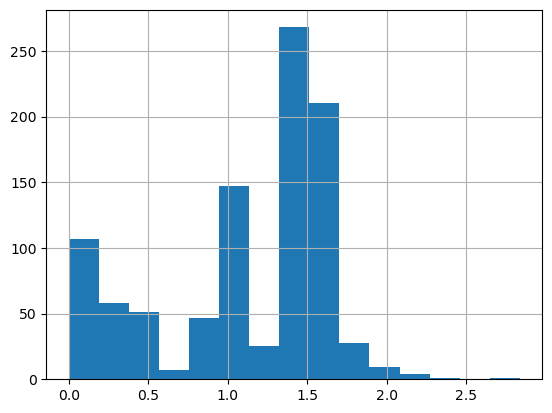

In [16]:
df_final[df_final.ApplicationDate>'2024-04-01'].IsGood.mean(), \
df_final[df_final.ApplicationDate>'2024-04-01'].IsGood.count(),\
df_final[df_final.ApplicationDate>'2024-04-01'].Payin.mean(),\
df_final[(df_final.ApplicationDate>'2024-04-01') & (df_final.Payin<1)].Payin.count(), \
df_final[(df_final.ApplicationDate>'2024-04-01') & (df_final.Payin<1)].Payin.mean(), \
df_final[(df_final.ApplicationDate>'2024-04-01') & (df_final.Payin>1)].Payin.count(), \
df_final[(df_final.ApplicationDate>'2024-04-01') & (df_final.Payin>1)].Payin.mean(), \
df_final[df_final.ApplicationDate>'2024-04-01'].Payin.hist(bins=15)

(0.44504896626768226,
 1838,
 0.8235418618241399,
 1006,
 0.3031837664015905,
 825,
 1.4580633696969698,
 <Axes: >)

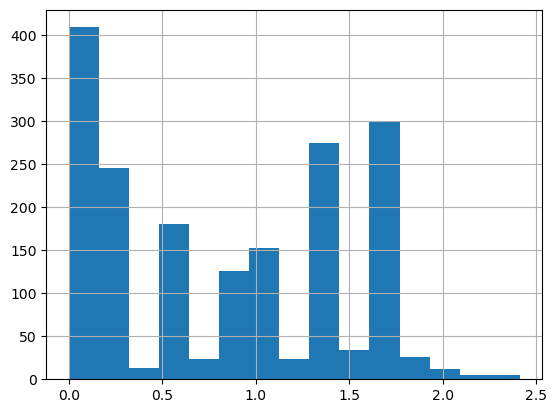

In [17]:
df_final[df_final.ApplicationDate<'2024-04-01'].IsGood.mean(), \
df_final[df_final.ApplicationDate<'2024-04-01'].IsGood.count(),\
df_final[df_final.ApplicationDate<'2024-04-01'].Payin.mean(),\
df_final[(df_final.ApplicationDate<'2024-04-01') & (df_final.Payin<1)].Payin.count(), \
df_final[(df_final.ApplicationDate<'2024-04-01') & (df_final.Payin<1)].Payin.mean(), \
df_final[(df_final.ApplicationDate<'2024-04-01') & (df_final.Payin>1)].Payin.count(), \
df_final[(df_final.ApplicationDate<'2024-04-01') & (df_final.Payin>1)].Payin.mean(), \
df_final[df_final.ApplicationDate<'2024-04-01'].Payin.hist(bins=15)

In [18]:
144/(144+84) # % of customers with payin > 1

0.631578947368421

In [19]:
df_final.ApplicationDate.max()

Timestamp('2024-08-20 14:17:29')

In [20]:
df_final[df_final.ApplicationDate == df_final.ApplicationDate.max()]

,AppID,CustomerID,ApplicationDate,Age,MaxHistory,CREDIT_TO_DEBIT_RATIO_MEAN,CREDIT_TO_DEBIT_RATIO_SD,DAILY_DEBIT_AMOUNT_MEAN,DAILY_INCOME_MEAN,DAILY_INCOME_REGULAR_MEAN,DEBIT_AMOUNT_Z,DEBIT_COUNT_Z,HIGHEST_PAY_DEPOSIT_MEAN,HIGHEST_PAY_FREQUENCY,INCOME_SOURCES_COUNT,MONTH_INFLOW_MEAN,MONTH_INFLOW_SD,MONTH_OUTFLOW_MEAN,MONTH_OUTFLOW_SD,MONTHS_WITH_FEES_RATE,MONTHS_WITH_EMPLOYMENT_RATE,NO_ACTIVITY_RATE,OD_AND_NSF_FEES_DAILY,RECURRENT_COUNT,RECURRING_RATE,BALANCE_MEAN,BALANCE_SD,BALANCE_ABOVE_RATE,LAST_BALANCE_ABOVE,AVG_BALANCE_ABOVE_7D,HIGHER_BALANCE_7D,NUM_LOAN_PMT,TOTAL_LOAN_PMT_AMT,NUM_LOAN_ORIG,TOTAL_LOAN_ORIG_AMT,PAYROLL_AMOUNT,TOTAL_CREDIT,TOTAL_DEBIT,NUM_STOP_PMT,NUM_NSF,NUM_OD,NUM_RETURN_PMT,NUM_GAMBLING_PMT,AMT_GAMBLING_PMT,IsGood,Payin
2638,27691,17103,2024-08-20 14:17:29,36.0,87,0.994169,0.159559,133.376,132.379,0.0,0.427288,0.707107,3971.37,41.0,0.0,3971.37,1045.236237,4001.28,879.24336,0.0,0.0,0.586207,0.0,0.0,0.0,470.147386,446.201084,0.670455,1,1,1,0.0,0.0,0.0,0.0,0.0,15885.48,16005.12,0,0,5,0,0,0.0,1,1.609666


In [31]:
a = df_final[(df_final.IsGood.notnull())].copy()
a[a.FPDAA==1].NUM_Bree.mean(), a[a.FPDAA==0].NUM_Bree.mean()

(348.6984126984127, 379.83187873220027)

Text(0, 0.5, 'Frequency Density')

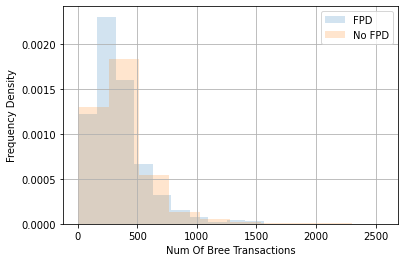

In [32]:
a[a.FPDAA==1].NUM_Bree.hist(alpha = 0.2, label = 'FPD', density = True)
a[a.FPDAA==0].NUM_Bree.hist(alpha = 0.2, label = 'No FPD', density = True)
plt.legend()
plt.xlabel('Num Of Bree Transactions')
plt.ylabel('Frequency Density')

In [40]:
a[(a.NUM_Bree < 300) & (a.ApplicationDate <'2024-08-01')].Payin.mean(), \
a[(a.NUM_Bree > 300) & (a.ApplicationDate <'2024-08-01')].Payin.mean(), \
a[(a.NUM_Bree > 300) & (a.ApplicationDate <'2024-08-01')].Payin.count(),\
a[(a.NUM_Bree < 300) & (a.ApplicationDate <'2024-08-01')].Payin.count(),

(0.8785486718367316, 0.941594795180715, 1494, 1225)

In [34]:
a.columns

Index(['AppID', 'CustomerID', 'ApplicationDate', 'Age', 'MaxHistory',
       'CREDIT_TO_DEBIT_RATIO_MEAN', 'CREDIT_TO_DEBIT_RATIO_SD',
       'DAILY_DEBIT_AMOUNT_MEAN', 'DAILY_INCOME_MEAN',
       'DAILY_INCOME_REGULAR_MEAN', 'DEBIT_AMOUNT_Z', 'DEBIT_COUNT_Z',
       'HIGHEST_PAY_DEPOSIT_MEAN', 'HIGHEST_PAY_FREQUENCY',
       'INCOME_SOURCES_COUNT', 'MONTH_INFLOW_MEAN', 'MONTH_INFLOW_SD',
       'MONTH_OUTFLOW_MEAN', 'MONTH_OUTFLOW_SD', 'MONTHS_WITH_FEES_RATE',
       'MONTHS_WITH_EMPLOYMENT_RATE', 'NO_ACTIVITY_RATE',
       'OD_AND_NSF_FEES_DAILY', 'RECURRENT_COUNT', 'RECURRING_RATE',
       'BALANCE_MEAN', 'BALANCE_SD', 'BALANCE_ABOVE_RATE',
       'LAST_BALANCE_ABOVE', 'AVG_BALANCE_ABOVE_7D', 'HIGHER_BALANCE_7D',
       'NUM_LOAN_PMT', 'TOTAL_LOAN_PMT_AMT', 'NUM_LOAN_ORIG',
       'TOTAL_LOAN_ORIG_AMT', 'PAYROLL_AMOUNT', 'TOTAL_CREDIT', 'TOTAL_DEBIT',
       'NUM_STOP_PMT', 'NUM_NSF', 'NUM_OD', 'NUM_RETURN_PMT',
       'NUM_GAMBLING_PMT', 'AMT_GAMBLING_PMT', 'NUM_EI_PMT', 'AMT_EI_PM

In [41]:
a[a.FPDAA==1].NUM_GAMBLING_PMT.mean(), a[a.FPDAA==0].NUM_GAMBLING_PMT.mean()

(16.68888888888889, 15.88562241616904)

(0.0, 100.0)

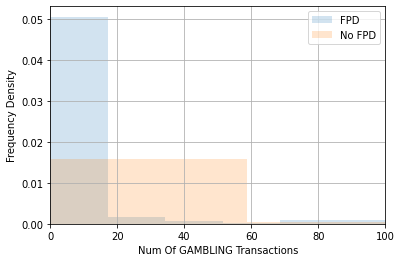

In [44]:
a[a.FPDAA==1].NUM_GAMBLING_PMT.hist(alpha = 0.2, label = 'FPD', density = True, bins= 30)
a[a.FPDAA==0].NUM_GAMBLING_PMT.hist(alpha = 0.2, label = 'No FPD', density = True, bins= 30)
plt.legend()
plt.xlabel('Num Of GAMBLING Transactions')
plt.ylabel('Frequency Density')
plt.xlim(0,100)

In [81]:
a['NUM_GAMBLING_PMT_20'] = (a.NUM_GAMBLING_PMT/20).astype(int) * 20
b = a[a.ApplicationDate>'2024-01-01'].groupby('NUM_GAMBLING_PMT_20').agg({'FPDAA':['count' ,'mean'], 'FPDFA':'mean', 'Payin':'mean'})
b.columns = ['Count', 'FPDAA', 'FPDFA','payin']
b['%'] = b['Count'] / b['Count'].sum()
b[b.iloc[:,0]>10]

,Count,FPDAA,FPDFA,payin,%
NUM_GAMBLING_PMT_20,,,,,
0,1298,0.148690,0.170866,1.076602,0.880000
20,44,0.227273,0.268293,0.956687,0.029831
40,24,0.166667,0.166667,0.936867,0.016271
60,20,0.150000,0.150000,1.042252,0.013559
80,17,0.352941,0.411765,0.942842,0.011525
140,11,0.454545,0.454545,0.795224,0.007458


In [82]:
a['AMT_GAMBLING_PMT_50'] = (a.AMT_GAMBLING_PMT/50).astype(int) * 50
b = a[a.ApplicationDate>'2024-01-01'].groupby('AMT_GAMBLING_PMT_50').agg({'FPDAA':['count' ,'mean'], 'FPDFA':'mean', 'Payin':'mean'})
b.columns = ['Count', 'FPDAA', 'FPDFA','Payin']
b['%'] = b['Count'] / b['Count'].sum()
b[b.iloc[:,0]>10]

,Count,FPDAA,FPDFA,Payin,%
AMT_GAMBLING_PMT_50,,,,,
0,1260,0.144444,0.164639,1.084933,0.854237
50,23,0.086957,0.130435,1.020339,0.015593
100,16,0.187500,0.200000,1.282520,0.010847
300,11,0.272727,0.272727,1.076608,0.007458


In [83]:
a['NUM_EI_PMT_80'] = (a.NUM_EI_PMT/80).astype(int) * 80
b = a[a.ApplicationDate>'2024-01-01'].groupby('NUM_EI_PMT_80').agg({'FPDAA':['count' ,'mean'], 'FPDFA':'mean', 'Payin':'mean'})
b.columns = ['Count', 'FPDAA', 'FPDFA','Payin']
b['%'] = b['Count'] / b['Count'].sum()
b[b.iloc[:,0]>10]

,Count,FPDAA,FPDFA,Payin,%
NUM_EI_PMT_80,,,,,
0,36,0.250000,0.285714,0.866336,0.024407
80,120,0.208333,0.239316,1.014848,0.081356
160,179,0.184358,0.211429,1.048622,0.121356
240,259,0.169884,0.196850,1.020178,0.175593
320,256,0.156250,0.166667,1.090868,0.173559
400,187,0.139037,0.163934,1.104104,0.126780
480,133,0.180451,0.207692,1.079188,0.090169
560,91,0.131868,0.177778,1.133360,0.061695
640,77,0.077922,0.081081,1.096380,0.052203


In [87]:
a['NUM_EI_PMT_20'] = (a.NUM_EI_PMT/20).astype(int) * 20
b = a[a.ApplicationDate>'2024-01-01'].groupby('NUM_EI_PMT_20').agg({'FPDAA':['count' ,'mean'], 'FPDFA':'mean', 'Payin':'mean'})
b.columns = ['Count', 'FPDAA', 'FPDFA','Payin']
b['%'] = b['Count'] / b['Count'].sum()
b[b.iloc[:,0]>10]

,Count,FPDAA,FPDFA,Payin,%
NUM_EI_PMT_20,,,,,
40,11,0.454545,0.454545,0.708515,0.007458
60,21,0.190476,0.250000,0.950355,0.014237
80,22,0.181818,0.227273,0.973082,0.014915
100,26,0.192308,0.230769,1.075077,0.017627
120,27,0.259259,0.320000,0.916510,0.018305
140,45,0.200000,0.204545,1.059469,0.030508
160,31,0.290323,0.322581,0.963157,0.021017
180,49,0.224490,0.244898,0.975854,0.033220
200,56,0.142857,0.173077,1.110377,0.037966


In [92]:
len(a[a.NUM_Bree>0].CustomerID.unique()), len(a)

(2793, 2807)

,AppID,CustomerID,ApplicationDate,Age,MaxHistory,CREDIT_TO_DEBIT_RATIO_MEAN,CREDIT_TO_DEBIT_RATIO_SD,DAILY_DEBIT_AMOUNT_MEAN,DAILY_INCOME_MEAN,DAILY_INCOME_REGULAR_MEAN,DEBIT_AMOUNT_Z,DEBIT_COUNT_Z,HIGHEST_PAY_DEPOSIT_MEAN,HIGHEST_PAY_FREQUENCY,INCOME_SOURCES_COUNT,MONTH_INFLOW_MEAN,MONTH_INFLOW_SD,MONTH_OUTFLOW_MEAN,MONTH_OUTFLOW_SD,MONTHS_WITH_FEES_RATE,MONTHS_WITH_EMPLOYMENT_RATE,NO_ACTIVITY_RATE,OD_AND_NSF_FEES_DAILY,RECURRENT_COUNT,RECURRING_RATE,BALANCE_MEAN,BALANCE_SD,BALANCE_ABOVE_RATE,LAST_BALANCE_ABOVE,AVG_BALANCE_ABOVE_7D,HIGHER_BALANCE_7D,NUM_LOAN_PMT,TOTAL_LOAN_PMT_AMT,NUM_LOAN_ORIG,TOTAL_LOAN_ORIG_AMT,PAYROLL_AMOUNT,TOTAL_CREDIT,TOTAL_DEBIT,NUM_STOP_PMT,NUM_NSF,NUM_OD,NUM_RETURN_PMT,NUM_GAMBLING_PMT,AMT_GAMBLING_PMT,NUM_EI_PMT,AMT_EI_PMT,NUM_Bree,IsGood,Payin,FPDAA,FPDFA,NUM_GAMBLING_PMT_10,NUM_GAMBLING_PMT_20,AMT_GAMBLING_PMT_20,AMT_GAMBLING_PMT_100,AMT_GAMBLING_PMT_50,AMT_GAMBLING_PMT_30,NUM_EI_PMT_10,NUM_EI_PMT_20,NUM_EI_PMT_50,NUM_EI_PMT_100,NUM_EI_PMT_80
0,276,217,2023-05-03 12:56:45,28.0,89,0.991452,0.015796,265.159083,264.257750,178.074111,-1.496047,-1.471057,5342.223333,4,0.0,7927.7325,5028.665391,7954.7725,5046.131630,0.75,0.0,0.955056,4.550562,0.0,0.0,32.239780,44.617901,0.000000,0,0,0,0,0.00,0.0,0.00,16026.67,31710.93,31819.09,0,9,0,0,0,0.0,658.0,31710.93,657.0,0,0.268933,1.0,1.0,0,0,0,0,0,0,650,640,650,600,640
1,559,463,2023-05-10 11:09:47,29.0,23,1.079348,0.350087,114.751833,126.027333,63.722167,0.707107,0.707107,1911.665000,2,0.0,3780.8200,660.833713,3592.5550,552.992858,0.50,0.0,0.695652,0.000000,0.0,0.0,216.366889,440.634449,0.222222,1,1,1,2,300.00,0.0,0.00,3822.93,7561.64,7185.11,0,0,0,0,0,0.0,68.0,7561.64,60.0,0,0.830400,0.0,0.0,0,0,0,0,0,0,60,60,50,0,0
2,861,709,2023-05-15 14:02:43,46.0,90,0.995773,0.046297,240.609250,236.780583,92.236417,-0.726860,-0.314176,3369.577500,21,0.0,7228.4175,4726.787789,7251.1525,4826.488975,1.00,0.0,0.555556,1.205444,0.0,0.0,65.120220,250.639644,0.098901,0,0,0,1,131.50,1.0,500.00,11063.15,28913.67,29004.61,0,14,3,1,0,0.0,674.0,28913.67,614.0,0,0.270900,1.0,1.0,0,0,0,0,0,0,670,660,650,600,640
3,1044,833,2023-05-17 15:14:30,57.0,83,1.188739,0.370218,150.916667,172.160500,56.491444,-0.244696,-0.115385,3818.757500,8.75,0.0,5289.8150,1738.630021,4823.6800,2030.802974,0.75,0.0,0.650602,0.000000,0.0,0.0,831.042198,535.658941,0.824176,1,1,1,6,1184.72,1.0,500.00,5080.23,21159.26,19294.72,0,0,0,0,14,358.0,219.0,21159.26,158.0,1,1.607700,0.0,0.0,10,0,340,300,350,330,210,200,200,200,160
4,1380,1014,2023-05-23 12:56:18,28.0,90,1.053158,0.093006,410.537917,438.818750,0.776000,-0.099578,0.046084,7580.980000,24.75,0.0,13439.5625,7119.594692,12667.4525,6513.799077,1.00,0.0,0.666667,2.180111,0.0,0.0,646.449890,779.309063,0.659341,1,1,1,6,1405.26,2.0,1100.00,0.00,53758.25,50669.81,0,2,4,5,172,6788.0,791.0,53758.25,755.0,0,0.000000,1.0,1.0,170,160,6780,6700,6750,6780,790,780,750,700,720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2802,24476,9340,2024-07-19 12:40:26,36.0,86,1.024767,0.056170,226.640917,227.325667,0.000000,-1.480337,-1.181590,4308.847500,14,0.0,11816.0050,4102.239965,11705.5700,4398.051848,0.75,0.0,0.639535,10.697674,0.0,0.0,502.775977,574.073295,0.678161,0,1,0,23,19470.00,59.0,19984.94,0.00,47264.02,46822.28,0,2,9,1,0,0.0,314.0,47264.02,309.0,1,1.374166,0.0,0.0,0,0,0,0,0,0,310,300,300,300,240
2803,24876,15239,2024-07-24 13:08:56,61.0,141,0.995818,0.138752,306.878400,320.402133,0.000000,-0.500282,-0.700051,7394.947500,120.25,0.0,10967.5440,7460.717142,11014.3520,7692.680547,0.60,0.0,0.695035,0.815603,0.0,0.0,318.634556,571.641690,0.466667,0,0,0,14,9040.00,36.0,6673.86,0.00,54837.72,55071.76,3,4,0,2,3,0.0,1081.0,54837.72,1073.0,1,1.374166,0.0,0.0,0,0,0,0,0,0,1080,1080,1050,1000,1040
2804,25063,15368,2024-07-25 15:00:49,27.0,87,100.000000,0.000000,186.892417,200.58983

Timestamp('2023-05-01 09:48:10')